In [1]:
import gc
import torch
import pandas as pd
import numpy as np

from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from utils.data_loader import get_data_loaders
from utils.xception import Mos_Xception
from utils.graph import draw_confusion_matrix

/home/bit/miniforge3/envs/pace-up/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.14 (you have 1.4.10). Upgrade using: pip install --upgrade albumentations


In [2]:
device = torch.device('cuda:0')

In [3]:
f1_list = []
pre_list = []
rec_list = []
acc_list = []

In [4]:
species_list = ['Aedes', 'Non-aedes']

In [5]:
y_true_list = []
y_pred_list = []

In [6]:
for fold in range(1, 6):
    model_path = f'model_weights/comparison/aedes_vs_non_aedes/fold_{fold}/model.pth'
    data_csv_path = f'data/comparison/aedes_vs_non_aedes/data_fold_{fold}.csv'

    df = pd.read_csv(data_csv_path)
    _, val_dl = get_data_loaders(df)

    net = Mos_Xception(2)
    net.load_state_dict(torch.load(model_path))
    net.to(device)
    net.eval()

    y_true = []
    y_pred = []

    with torch.no_grad():
        for data in val_dl:
            x = data[0].to(device)
            y = data[1].numpy()
            out = net(x).cpu().numpy()

            for logits, label in zip(out, y):
                y_true.append(label)
                y_pred.append(np.argmax(logits))

    f1 = f1_score(y_true, y_pred, average='macro')
    pre = precision_score(y_true, y_pred, average='macro')
    rec = recall_score(y_true, y_pred, average='macro')
    acc = accuracy_score(y_true, y_pred)

    y_true_list.append(y_true)
    y_pred_list.append(y_pred)

    f1_list.append(f1)
    pre_list.append(pre)
    rec_list.append(rec)
    acc_list.append(acc)

    del net
    gc.collect()
    torch.cuda.empty_cache()

In [7]:
y_true_list = sum(y_true_list, [])
y_pred_list = sum(y_pred_list, [])

In [8]:
np.mean(f1_list)

0.9993315285908348

In [9]:
np.mean(acc_list)

0.9994152046783625

In [10]:
cm = confusion_matrix(y_true_list, y_pred_list, normalize='true')
cm = np.round(cm, 2)

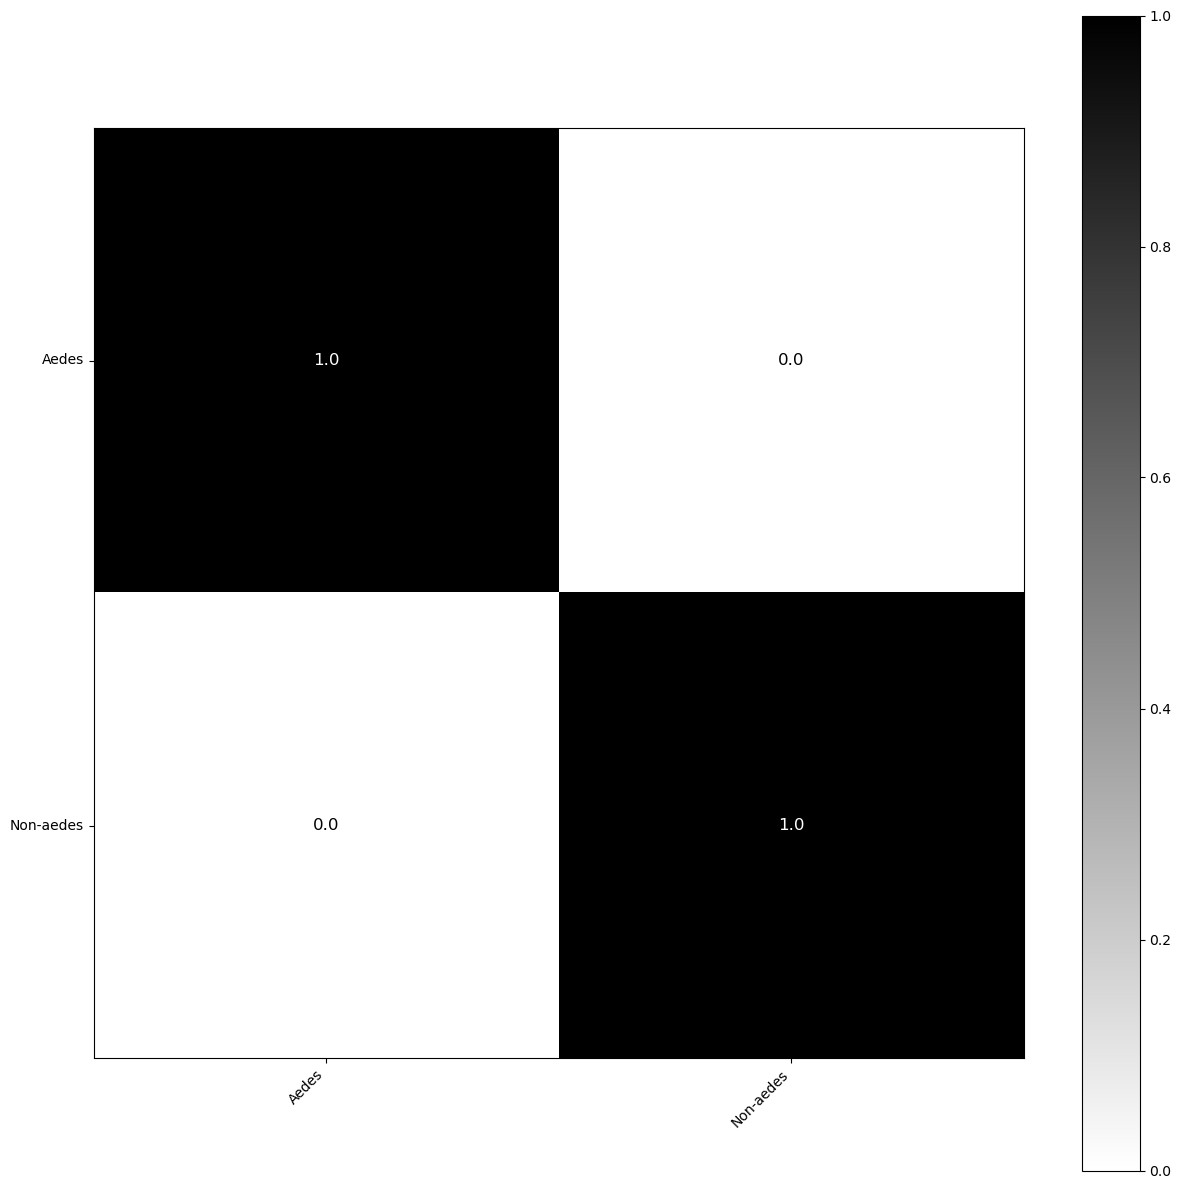

In [11]:
draw_confusion_matrix(cm, species_list)